# Transmembrane vs soluble proteins

How does the type of protein affect the performances of our model?
Transmembrane proteins assume a specific structure when they nest into the cellular membrane (e.g. non-polar residues on the outside), 
while soluble proteins are usually surrounded by water (e.g. polar residues on the outside). 
This information however is not provided during training and all samples are treated equally.

Run this to create `membrane` and `non_membrane` folders in `data`.

In [ ]:
import shutil
import itertools
import pandas as pd

from pathlib import Path

membrane = set(pd.read_csv('membrane.txt', usecols=[0], sep='\s+', header=None, squeeze=True))
non_membrane = set(pd.read_csv('non-membrane.txt', usecols=[0], sep='\s+', header=None, squeeze=True))

data_path = Path('../../../data')
membrane_path = data_path.joinpath('membrane')
non_membrane_path = data_path.joinpath('non_membrane')
membrane_path.mkdir(exist_ok=True)
non_membrane_path.mkdir(exist_ok=True)

for protein in data_path.glob('CASP1?/T*.npz'):
    if protein.with_suffix('').name in membrane:
        dest = membrane_path
    elif protein.with_suffix('').name in non_membrane:
        dest = non_membrane_path
    else:
        continue
    print(protein.name, dest.name)
    shutil.copy(protein, dest.joinpath(protein.name))

Then run the evaluation script on the proteins in `data/membrane` and `data/non_membrane`, which will put the results in `results/allfeatures/membrane` and `results/allfeatures/non_membrane`.

Here follows the analysis of the results.

In [2]:
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
with open('../../../results/allfeatures/membrane/test.yaml') as f:
    membrane = yaml.safe_load(f)['test']['metric']
with open('../../../results/allfeatures/non_membrane/test.yaml') as f:    
    non_membrane = yaml.safe_load(f)['test']['metric']

In [4]:
df = pd.DataFrame(
    [(k, kk, 'membrane', membrane[k][kk]) for k in membrane for kk in membrane[k]] +
    [(k, kk, 'non_membrane', non_membrane[k][kk]) for k in non_membrane for kk in non_membrane[k]],
    columns = ['output', 'metric', 'target_type', 'value']
)
df = df.pivot_table(index=['output', 'metric'], columns='target_type', values='value')
df.transpose().style \
    .highlight_max(axis='index', color='; color: DodgerBlue; font-weight: bold;', subset=[c for c in df.index if c[1] not in {'rmse', 'first_rank_loss', 'ranking'}]) \
    .highlight_min(axis='index', color='; color: green; font-weight: bold;', subset=[c for c in df.index if c[1] in {'rmse', 'first_rank_loss', 'ranking'}])

In [5]:
print(
    df.transpose()
    .sort_index()
    .drop(columns=('global_gdtts', 'ranking'))
    .applymap('{:.3f}'.format)
    .to_csv()
          .replace('global_gdtts', '\\gdtts').replace('local_lddt', '\\lddt').replace('output','').replace('metric','')
          .replace('first_rank_loss', 'FRL')
          .replace('rmse', 'RMSE')
          .replace('per_target_pearson', r'$R_\text{target}$')
          .replace('per_model_pearson', r'$R_\text{model}$')
          .replace('pearson', r'$R$')
          .replace('per_target_spearman', r'$\rho_\text{target}$')
          .replace('per_model_spearman', r'$\rho_\text{model}$')
          .replace('per_target_kendall', r'$\tau_\text{target}$')
          .replace('per_model_kendall', r'$\tau_\text{model}$')
          .replace('spearman', r'$\rho$')
          .replace('kendall', r'$\tau$')
)

,\gdtts,\gdtts,\gdtts,\gdtts,\gdtts,\gdtts,\gdtts,\gdtts,\lddt,\lddt,\lddt
,FRL,$\tau$,$R$,$\tau_\text{target}$,$R_\text{target}$,$\rho_\text{target}$,RMSE,$\rho$,$R$,$R_\text{model}$,RMSE
target_type,,,,,,,,,,,
membrane,0.092,0.523,0.714,0.328,0.538,0.463,0.209,0.714,0.679,0.487,0.170
non_membrane,0.076,0.594,0.790,0.361,0.627,0.500,0.177,0.796,0.770,0.532,0.155



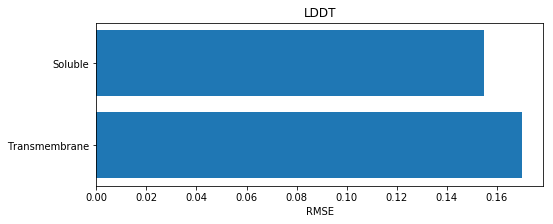

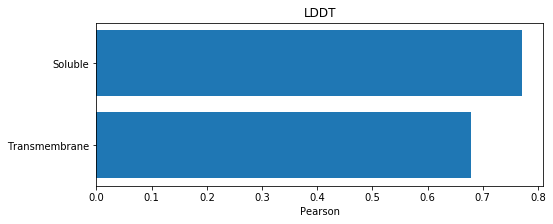

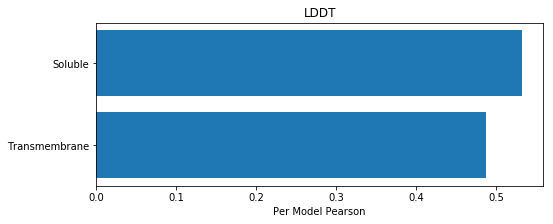

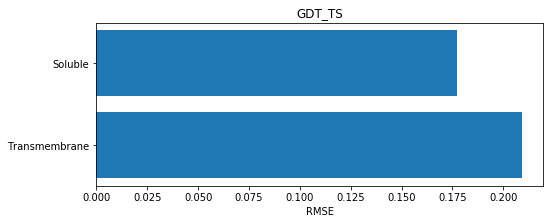

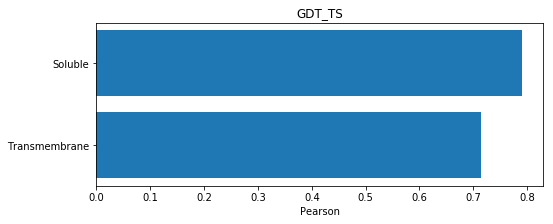

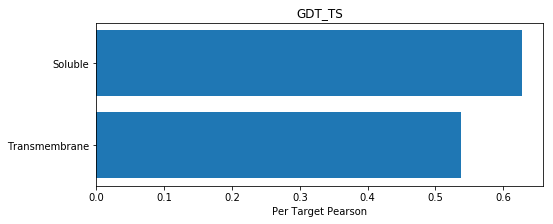

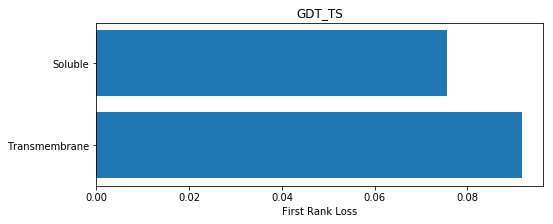

In [6]:
for k in membrane:
    for kk in membrane[k]:
        if 'kendall' in kk or 'spearman' in kk or 'ranking' in kk:
            continue
        fig, ax = plt.subplots(1, 1, figsize=(8, 3))
        ax.barh(['Transmembrane', 'Soluble'], [membrane[k][kk], non_membrane[k][kk]])
        
        fig.set_facecolor('white')
        ax.set_ylabel(None)
        ax.set_title(f'{"LDDT" if "lddt" in k else "GDT_TS"}')
        ax.set_xlabel('RMSE' if kk == 'rmse' else kk.replace('_', ' ').title())

        fig.savefig(f'transmembrane_vs_soluble__{k}_{kk}.png')
        fig.savefig(f'transmembrane_vs_soluble__{k}_{kk}.pdf', bbox_inches='tight', pad_inches=0.01)
        display(fig)
        plt.close(fig)